The accuracy is:  66.14583333333334 %
With a number of  10 base models we receive an accuracy of  73.2 %


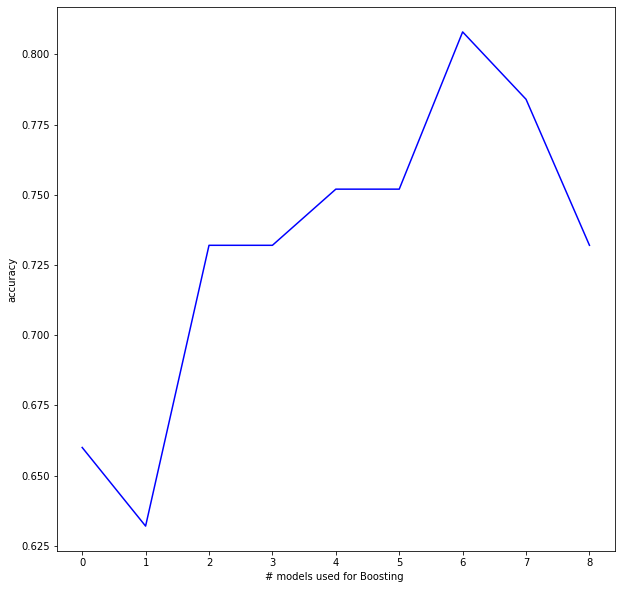

With a number of  25 base models we receive an accuracy of  76.4 %
With a number of  50 base models we receive an accuracy of  78.4 %


In [8]:
# Reference: https://www.python-course.eu/Boosting.php

import numpy as np
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

dataset = pd.read_csv("/content/tic-tac-toe_train.csv", header=None)
dataset = dataset.sample(frac=1)
dataset.columns = ["A", "B", "C", "D", "E",
                   "F", "G", "H", "I", "Decision"]

test_dataset = pd.read_csv("/content/tic-tac-toe_test.csv", header=None)
test_dataset = dataset.sample(frac=1)
test_dataset.columns = ["A", "B", "C", "D", "E",
                        "F", "G", "H", "I", "Decision"]

for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(
        dataset[label]).transform(dataset[label])

Tree_model = DecisionTreeClassifier(criterion="entropy", max_depth=1)
X = dataset.drop('Decision', axis=1)
Y = dataset['Decision'].where(dataset['Decision'] == 1, -1)
predictions = np.mean(cross_validate(Tree_model, X, Y, cv=80)['test_score'])
print('The accuracy is: ', predictions*100, '%')


class Boosting:

    def __init__(self, dataset, T, test_dataset):
        self.dataset = dataset
        self.T = T
        self.test_dataset = test_dataset
        self.alphas = None
        self.models = None
        self.accuracy = []
        self.predictions = None

    def fit(self):
        # Set the descriptive features and the target feature
        X = self.dataset.drop(['Decision'], axis=1)
        Y = self.dataset['Decision'].where(self.dataset['Decision'] == 1, -1)

        # Initialize the weights of each sample with wi = 1/N and create a dataframe in which the evaluation is computed
        Evaluation = pd.DataFrame(Y.copy())
        # Set the initial weights w = 1/N
        Evaluation['weights'] = 1/len(self.dataset)

        # Run the boosting algorithm by creating T "weighted models"

        alphas = []
        models = []

        for t in range(self.T):

            # Train the Decision Stump(s)
            # Mind the deth one --> Decision Stump
            Tree_model = DecisionTreeClassifier(
                criterion="entropy", max_depth=1)

            model = Tree_model.fit(
                X, Y, sample_weight=np.array(Evaluation['weights']))

            # Append the single weak classifiers to a list which is later on used to make the
            # weighted decision
            models.append(model)
            predictions = model.predict(X)
            score = model.score(X, Y)

            # Add values to the Evaluation DataFrame
            Evaluation['predictions'] = predictions
            Evaluation['evaluation'] = np.where(
                Evaluation['predictions'] == Evaluation['Decision'], 1, 0)
            Evaluation['misclassified'] = np.where(
                Evaluation['predictions'] != Evaluation['Decision'], 1, 0)

            # Calculate the misclassification rate and accuracy
            accuracy = sum(Evaluation['evaluation']) / \
                len(Evaluation['evaluation'])
            misclassification = sum(
                Evaluation['misclassified'])/len(Evaluation['misclassified'])

            # Caclulate the error
            err = np.sum(
                Evaluation['weights']*Evaluation['misclassified'])/np.sum(Evaluation['weights'])

            # Calculate the alpha values
            alpha = np.log((1-err)/err)
            alphas.append(alpha)

            # Update the weights wi --> These updated weights are used in the sample_weight parameter
            # for the training of the next decision stump.
            Evaluation['weights'] *= np.exp(alpha*Evaluation['misclassified'])

            #print('The Accuracy of the {0}. model is : '.format(t+1),accuracy*100,'%')
            #print('The missclassification rate is: ',misclassification*100,'%')

        self.alphas = alphas
        self.models = models

    def predict(self):
        X_test = self.test_dataset.drop(['Decision'], axis=1).reindex(
            range(len(self.test_dataset)))
        Y_test = self.test_dataset['Decision'].reindex(
            range(len(self.test_dataset))).where(self.dataset['Decision'] == 1, -1)

        # With each model in the self.model list, make a prediction

        accuracy = []
        predictions = []

        for alpha, model in zip(self.alphas, self.models):
            # We use the predict method for the single decisiontreeclassifier models in the list
            prediction = alpha*model.predict(X_test)
            predictions.append(prediction)
            self.accuracy.append(np.sum(np.sign(
                np.sum(np.array(predictions), axis=0)) == Y_test.values)/len(predictions[0]))

        self.predictions = np.sign(np.sum(np.array(predictions), axis=0))


##Plot the accuracy of the model against the number of stump-models used##########
number_of_base_learners1 = 10
number_of_base_learners2 = 25
number_of_base_learners3 = 50
fig = plt.figure(figsize=(10, 10))
ax0 = fig.add_subplot(111)


for i in range(number_of_base_learners1):
    model = Boosting(dataset, i, dataset)
    model.fit()
    model.predict()

ax0.plot(range(len(model.accuracy)), model.accuracy, '-b')
ax0.set_xlabel('# models used for Boosting ')
ax0.set_ylabel('accuracy')
print('With a number of ', number_of_base_learners1,
      'base models we receive an accuracy of ', model.accuracy[-1]*100, '%')

plt.show()

for i in range(number_of_base_learners2):
    model = Boosting(dataset, i, dataset)
    model.fit()
    model.predict()

ax0.plot(range(len(model.accuracy)), model.accuracy, '-b')
ax0.set_xlabel('# models used for Boosting ')
ax0.set_ylabel('accuracy')
print('With a number of ', number_of_base_learners2,
      'base models we receive an accuracy of ', model.accuracy[-1]*100, '%')

plt.show()

for i in range(number_of_base_learners3):
    model = Boosting(dataset, i, dataset)
    model.fit()
    model.predict()

ax0.plot(range(len(model.accuracy)), model.accuracy, '-b')
ax0.set_xlabel('# models used for Boosting ')
ax0.set_ylabel('accuracy')
print('With a number of ', number_of_base_learners3,
      'base models we receive an accuracy of ', model.accuracy[-1]*100, '%')

plt.show()
